# ETL Project - 2020 Opioid Data Hackathon

In [106]:
#!pip install mysql-connector-python
#!pip install pymysql

     |████████████████████████████████| 47 kB 571 kB/s eta 0:00:011


In [107]:
# Import Libraries
import numpy as mp
import pandas as pd
import datetime
import seaborn as sns
import mysql.connector

from mysql.connector import Error
from mysql.connector import errorcode
import pymysql

### Prevention Point

#### Naloxone refill_events
In many states, individuals must receive a prescription to carry overdose reversal drugs like Narcan (Naloxone). In 2014, Pennsylvania passed legislation allowing any citizen who could be in the position to administer overdose reversal drugs to receive, carry, and administer such drugs. Prevention Point, among other locations, trains and hands out refills for Narcan (Naloxone).  Narcan is an overdose reversal drug administered either intravenously or intranalasally. 

Individuals receiving training or refills through Prevention Point are required to fill out a questionnaire about their experiences with overdoses and related demographic information.


### Research Questions

It's very important that we look at the recovery process with regards to building understanding in the general public. We want to know whether prescribing/refilling Narcan could help the patient to survived or not.

Here are things we want to look at when we load data:

We have all naloxone refills of Naloxone at PP and all overdose responses and naloxone administrations in Philadelphia in 2018. We want to build a scheme that contains the number and amount of naloxone refills each month and the survival rate and rate of naloxone administered for overdose incidents each month.


Acronyms:

* PP: Prevention Point
* SEP: Syringe Exchange Program
* HF: Health Federation
* DPH: Department of Public Health
* ED: Emergency Department
* EMS: Emergency Medical Services
* OD: Overdose


In [27]:
# Information on overdose responses and naloxone administrations.
overdose= pd.read_csv("/Users/zixiliu/LouisvilleProject_files/datahack2020/data/psp_overdose_events.csv")

# Information collected at time of naloxone refills of Naloxone at PP.
refill= pd.read_csv("/Users/zixiliu/LouisvilleProject_files/datahack2020/data/data_pp_refill-14-feb/pp_refill_events.csv")

# pp_refill_events measures aggregated by participant zipcode.
refill_zips= pd.read_csv("/Users/zixiliu/LouisvilleProject_files/datahack2020/data/data/pp_refill_zipcode_metrics.csv")

# overdose mortality by residential zip
mortality_res= pd.read_csv("/Users/zixiliu/LouisvilleProject_files/datahack2020/data/data/dph_od_resident_counts.csv")

# overdose mortality by incident zip
mortality_inc= pd.read_csv("/Users/zixiliu/LouisvilleProject_files/datahack2020/data/data/dph_od_incident_counts.csv")

In [28]:
#efficient way to extract month from string format date
refill['refill_month'] = pd.DatetimeIndex(refill['refill_date']).month
overdose['Incident Month'] = pd.DatetimeIndex(overdose['Incident Date']).month

## Data Cleaning

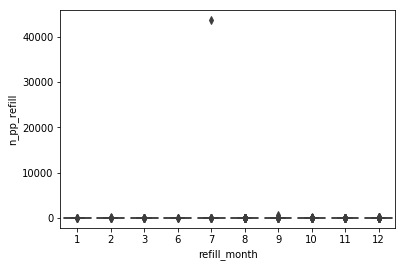

In [38]:
# The variables of interest are:
# n_pp_refill: number of naloxone refills received at PP
# ml_naloxone: amount of naloxone used by participant
refill_cleaned = refill.dropna(subset=['n_pp_refill', 'ml_naloxone'])

# Examine whether there is outlier in n_pp_refill
sns.boxplot(x=refill_cleaned['refill_month'],y=refill_cleaned['n_pp_refill'])

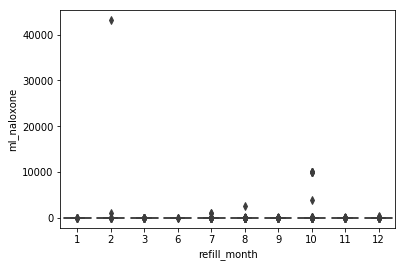

In [39]:
# Examine whether there is outlier in ml_naloxone
sns.boxplot(x=refill_cleaned['refill_month'],y=refill_cleaned['ml_naloxone'])

In [50]:
refill_cleaned = refill_cleaned[(refill_cleaned.n_pp_refill<1000) & (refill_cleaned.ml_naloxone<1000)]

In [54]:
# The variables of interest are:
# Naloxone Administered: Field identifying whether or not naloxone was administered. Possible values: Y, N
# survive: Describes if the victim survived the incident. Possible values: Y, N, U. (U=Unknown is a value assigned by the person entering the data. In some cases the responder may not know if the victim survived.)
overdose_cleaned = overdose.dropna(subset=['Naloxone Administered', 'Survive'])

## Transform

In [58]:
# Summarize total number of naloxone refills received at PP and total amount of naloxone used by participant by month
refill_bymonth = refill_cleaned.groupby('refill_month').aggregate({'n_pp_refill': 'sum',
                             'ml_naloxone': 'sum'}).reset_index()

In [79]:
# Summarize total number of incidents by month and survival
overdose_mon_survival = overdose_cleaned.groupby(['Incident Month', 'Survive']).aggregate({'Incident ID': 'count'}).reset_index().rename(columns={'Incident ID': 'Count_Survival'})

# Summarize total number of incidents by month and Naloxone Administered
overdose_mon_naloxone = overdose_cleaned.groupby(['Incident Month', 'Naloxone Administered']).aggregate({'Incident ID': 'count'}).reset_index().rename(columns={'Naloxone Administered': 'Naloxone_Administered',
'Incident ID':'Count_Naloxone_Admin'})

# Summarize total number of incidents by month 
overdose_bymonth = overdose_cleaned.groupby('Incident Month').aggregate({'Incident ID': 'count'}).reset_index().rename(columns={'Incident ID': 'Count'})

In [80]:
overdose_merge1 = pd.merge(overdose_bymonth, overdose_mon_survival[overdose_mon_survival.Survive == "Y"], on = "Incident Month")
overdose_merge2 = pd.merge(overdose_merge1, overdose_mon_naloxone[overdose_mon_naloxone.Naloxone_Administered == "Y"], on = "Incident Month")

overdose_merge2['Survival_Rate'] = overdose_merge2['Count_Survival']/overdose_merge2['Count']
overdose_merge2['Naloxone_Admin_Rate'] = overdose_merge2['Count_Naloxone_Admin']/overdose_merge2['Count']

In [88]:
db = pd.merge(overdose_merge2[['Incident Month', 'Survival_Rate', 'Naloxone_Admin_Rate']],refill_bymonth, left_on = "Incident Month", right_on = "refill_month")
db = db[['Incident Month', 'Survival_Rate', 'Naloxone_Admin_Rate', 'n_pp_refill', 'ml_naloxone']].rename(columns={'Incident Month': 'Month'})

In [89]:
db

,Month,Survival_Rate,Naloxone_Admin_Rate,n_pp_refill,ml_naloxone
0,1,0.761768,0.659942,246.0,48.3
1,2,0.759657,0.699571,442.0,43.4
2,3,0.710843,0.630522,548.0,67.9
3,6,0.746556,0.615702,124.0,27.2
4,7,0.761905,0.678399,847.0,1179.8
5,8,0.754142,0.617628,1574.0,2652.6
6,9,0.752274,0.641008,1684.0,1697.0
7,10,0.746349,0.676403,1414.0,3244.0
8,11,0.755285,0.660163,928.0,1653.0
9,12,0.715342,0.686691,2695.0,3094.0


## Load

In [103]:
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='OpioidData',
                                         user='root',
                                         password='Twi1ight')
    mySql_Create_Table_Query = """CREATE TABLE Naloxone_Month (Month int, 
    Survival_rate float, Naloxone_Rate float, n_pp_refill int, ml_naloxone float, PRIMARY KEY (Month))"""

    cursor = connection.cursor()
    result = cursor.execute(mySql_Create_Table_Query)
    print("Naloxone_Month Table created successfully ")

except mysql.connector.Error as error:
    print("Failed to create table in MySQL: {}".format(error))
finally:
    if (connection.is_connected()):
        cursor.close()
        connection.close()
        print("MySQL connection is closed")


Naloxone_Month Table created successfully 
MySQL connection is closed


In [104]:
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='OpioidData',
                                         user='root',
                                         password='Twi1ight')
    mySql_insert_query = """INSERT INTO Naloxone_Month (Month, Survival_rate, Naloxone_Rate, n_pp_refill, ml_naloxone) 
                            VALUES (%s, %s, %s, %s) """

    cursor = connection.cursor()
    cursor.execute(mySql_insert_query)
    connection.commit()
    print(cursor.rowcount, "Record inserted successfully into Laptop table")
    cursor.close()

except mysql.connector.Error as error:
    print("Failed to insert record into Laptop table {}".format(error))

finally:
    if (connection.is_connected()):
        connection.close()
        print("MySQL connection is closed")

Connected to MySQL Server version  8.0.20
You're connected to database:  ('opioiddata',)
MySQL connection is closed


In [108]:
# Connect to the database
connection = pymysql.connect(host='localhost',
                             database='OpioidData',
                             user='root',
                             password='Twi1ight')


# create cursor
cursor=connection.cursor()

# Insert DataFrame recrds one by one.
sql = "INSERT INTO Naloxone_Month (Month, Survival_rate, Naloxone_Rate, n_pp_refill, ml_naloxone) VALUES(%s,%s,%s,%s,%s)"
for i,row in db.iterrows():
    cursor.execute(sql, tuple(row))

    # the connection is not autocommitted by default, so we must commit to save our changes
    connection.commit()

connection.close()

We take a look at the Naloxone_Month Data we stored.

In [114]:
# Connect to the database
connection = pymysql.connect(host='localhost',
                             database='OpioidData',
                             user='root',
                             password='Twi1ight')


# create cursor
cursor=connection.cursor()

# Execute query 
sql = "SELECT * FROM `Naloxone_Month`"
cursor.execute(sql) 
# Fetch all the records 
result = cursor.fetchall() 
for i in result: 
    print(i)
    
connection.close()

(1, 0.761768, 0.659942, 246, 48.3)
(2, 0.759657, 0.699571, 442, 43.4)
(3, 0.710843, 0.630522, 548, 67.9)
(6, 0.746556, 0.615702, 124, 27.2)
(7, 0.761905, 0.678399, 847, 1179.8)
(8, 0.754142, 0.617628, 1574, 2652.6)
(9, 0.752274, 0.641008, 1684, 1697.0)
(10, 0.746349, 0.676403, 1414, 3244.0)
(11, 0.755285, 0.660163, 928, 1653.0)
(12, 0.715342, 0.686691, 2695, 3094.0)
